In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import chi2, mutual_info_classif

In [3]:
# Load the data
data = pd.read_excel('./data/data_extended.xlsx')

# Display the first few rows of the data
print(data.head())

         SourceType                                  SourceDescription  \
0          Database                      Contains customer information   
1     System/Server                      Stores web server access logs   
2   Web Application                           Online shopping platform   
3            Device                        Records employee work hours   
4  Software/Program  Allows users to access bank accounts on mobile...   

            TargetName        TargetType  \
0           CRM System     System/Server   
1        SIEM Platform  Software/Program   
2      Payment Gateway           Service   
3       Payroll System     System/Server   
4  Core Banking System     System/Server   

                                   TargetDescription            Relationship  \
0            Customer Relationship Management system               Data Sync   
1  Security Information and Event Management plat...         Log Aggregation   
2                       Handles payment transactio

In [4]:
for col in data.columns:
    print(col)

SourceType
SourceDescription
TargetName
TargetType
TargetDescription
Relationship
AuthRequired
Encryption
EncryptionType
DataFormat
Frequency
DataIntegrity
AccessType
AccessTarget
NetworkProtocol
CommunicationChannel
CredentialStorage
Interactor
Threat


In [5]:
data = data[["SourceType", "TargetType", "AuthRequired", "Encryption", "EncryptionType", "DataFormat", "Frequency", "DataIntegrity", "AccessType",
             "AccessTarget", "NetworkProtocol", "CommunicationChannel", "CredentialStorage", "Interactor", "Threat"]]

In [6]:
data = data.replace([None, ''], pd.NA)

# Now, count the number of empty cells per column
empty_counts = data.isna().sum()

# Print the counts
print("Number of empty rows per col: ")
print(empty_counts)

Number of empty rows per col: 
SourceType              0
TargetType              0
AuthRequired            0
Encryption              0
EncryptionType          0
DataFormat              0
Frequency               0
DataIntegrity           0
AccessType              0
AccessTarget            0
NetworkProtocol         0
CommunicationChannel    0
CredentialStorage       0
Interactor              0
Threat                  0
dtype: int64


In [7]:
class_counts = data['Threat'].value_counts()
class_counts

Threat
Cross-Site Scripting (XSS)              507
Phishing Attacks                        506
Man-in-the-Middle (MitM) Attack         468
API Security Breach                     462
Malware Attack                          457
Malvertising                            445
SQL Injection                           427
Spear Phishing Attacks                  422
Ransomware Attack                       412
No Threat                               401
Zero-day Exploit                        394
Cryptojacking                           369
Cross-Site Request Forgery (CSRF)       209
Remote Code Execution (RCE)             204
Drive-by Download Attacks               200
Credential Stuffing                     191
Directory Traversal                     183
Distributed Denial of Service (DDoS)    176
Side-Channel Attack                     171
Password Attack                         153
Denial of Service (DoS)                  78
Name: count, dtype: int64

In [8]:
# Remove classes with fewer than X instances
valid_classes = class_counts[class_counts > 20].index
data = data[data['Threat'].isin(valid_classes)]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6835 entries, 0 to 6834
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SourceType            6835 non-null   object
 1   TargetType            6835 non-null   object
 2   AuthRequired          6835 non-null   object
 3   Encryption            6835 non-null   object
 4   EncryptionType        6835 non-null   object
 5   DataFormat            6835 non-null   object
 6   Frequency             6835 non-null   object
 7   DataIntegrity         6835 non-null   object
 8   AccessType            6835 non-null   object
 9   AccessTarget          6835 non-null   object
 10  NetworkProtocol       6835 non-null   object
 11  CommunicationChannel  6835 non-null   object
 12  CredentialStorage     6835 non-null   object
 13  Interactor            6835 non-null   object
 14  Threat                6835 non-null   object
dtypes: object(15)
memory usage: 801.1+ KB


In [10]:
unique_values_count = data.nunique()

value_counts_per_column = {col: data[col].value_counts() for col in data.columns}

unique_values_count, value_counts_per_column


(SourceType               7
 TargetType               7
 AuthRequired             2
 Encryption               2
 EncryptionType           6
 DataFormat               8
 Frequency                5
 DataIntegrity            4
 AccessType               5
 AccessTarget             8
 NetworkProtocol          8
 CommunicationChannel     7
 CredentialStorage        7
 Interactor               7
 Threat                  21
 dtype: int64,
 {'SourceType': SourceType
  Web Application     1385
  Device              1282
  Database            1189
  Service              988
  System/Server        820
  Software/Program     773
  User                 398
  Name: count, dtype: int64,
  'TargetType': TargetType
  Service             2016
  Database            1161
  Web Application     1135
  System/Server       1113
  Software/Program     834
  Device               289
  User                 287
  Name: count, dtype: int64,
  'AuthRequired': AuthRequired
  Yes    5470
  No     1365
  Name: count, d

In [11]:
print(data.describe(include='all'))

             SourceType TargetType AuthRequired Encryption EncryptionType  \
count              6835       6835         6835       6835           6835   
unique                7          7            2          2              6   
top     Web Application    Service          Yes        Yes        TLS/SSL   
freq               1385       2016         5470       5462           1712   

       DataFormat  Frequency DataIntegrity AccessType AccessTarget  \
count        6835       6835          6835       6835         6835   
unique          8          5             4          5            8   
top          JSON  Real-Time          Hash      Write     Database   
freq         2689       3235          2197       2842         3111   

       NetworkProtocol CommunicationChannel CredentialStorage Interactor  \
count             6835                 6835              6835       6835   
unique               8                    7                 7          7   
top         HTTP/HTTPS             

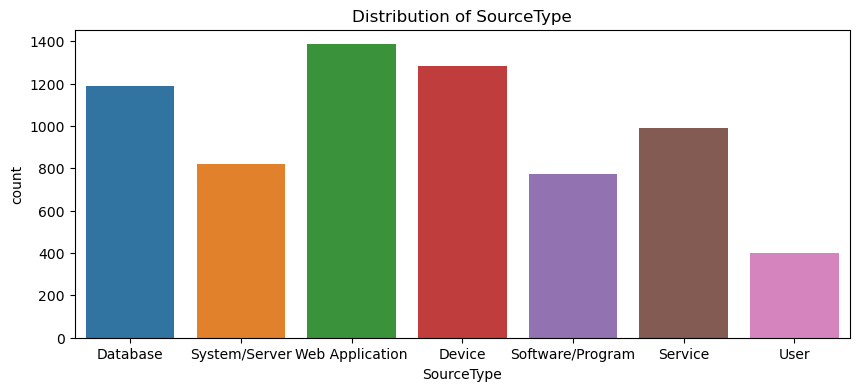

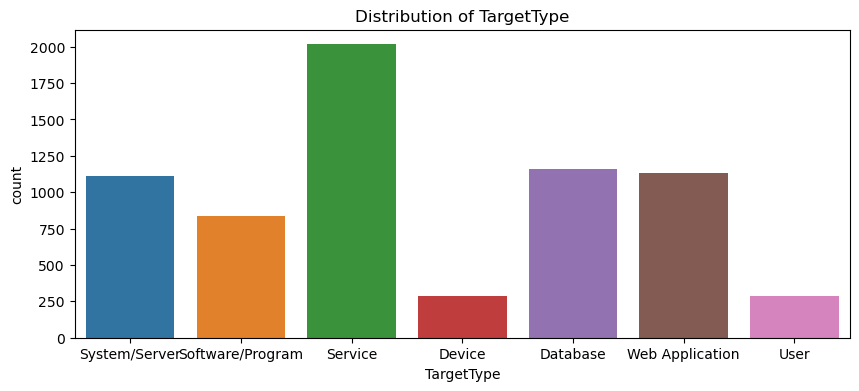

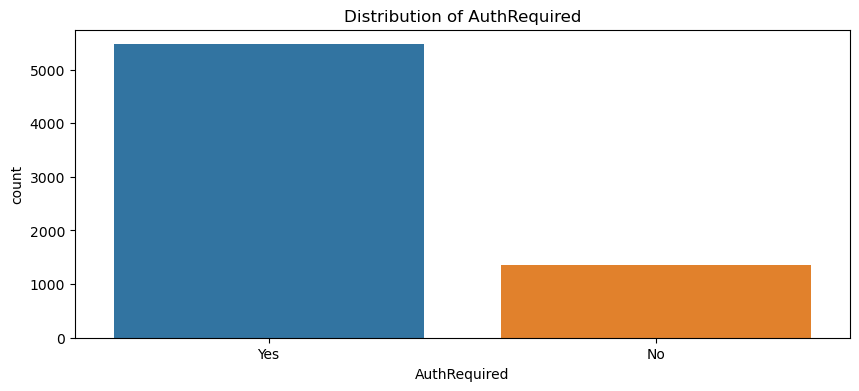

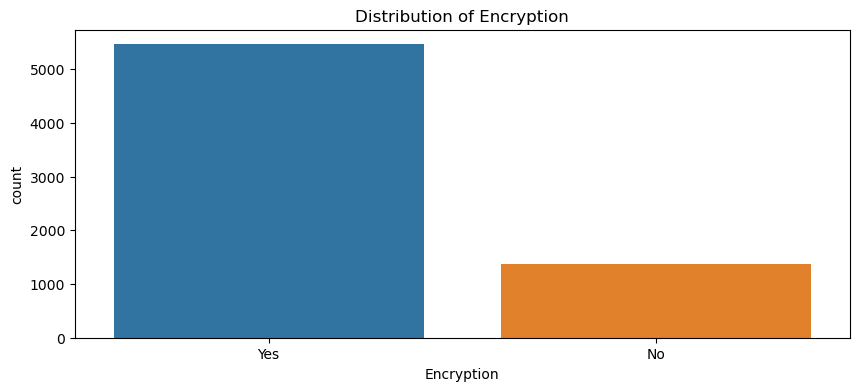

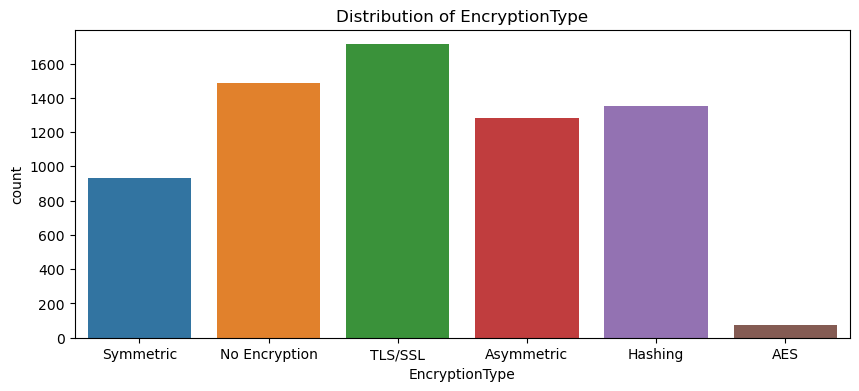

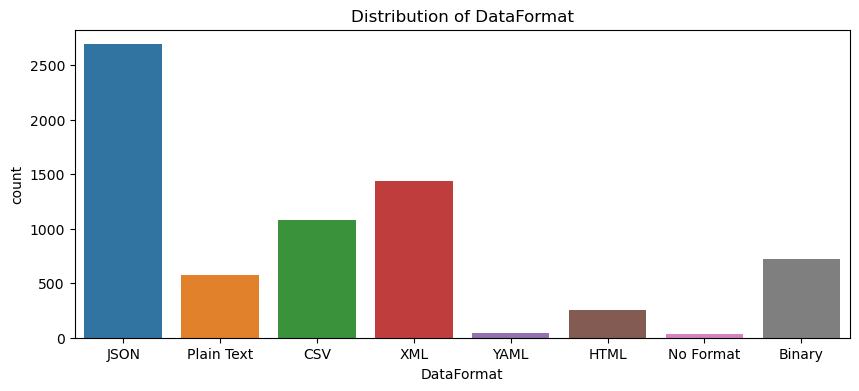

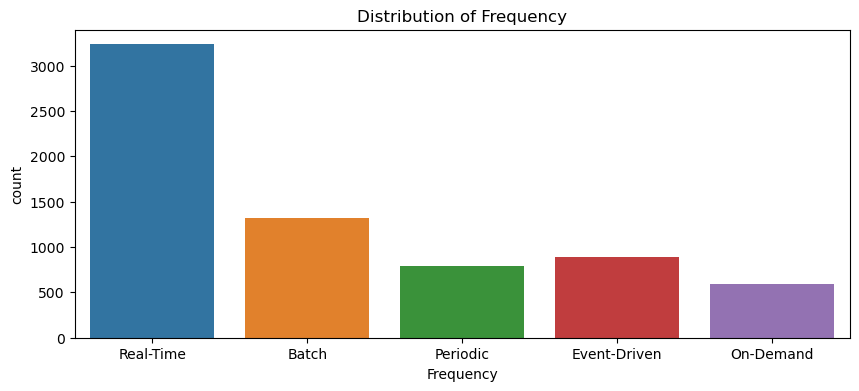

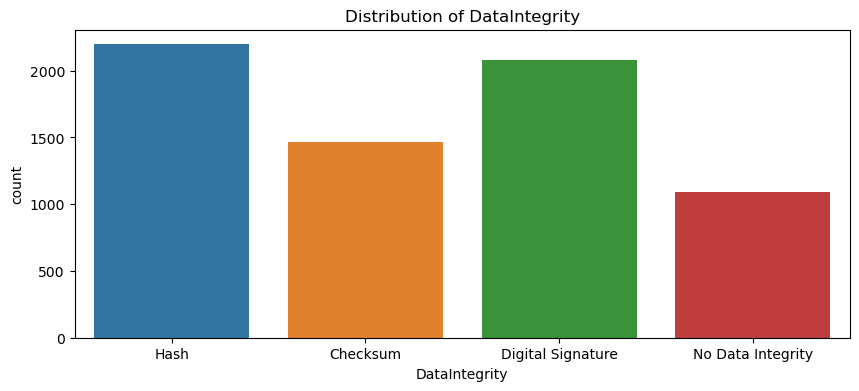

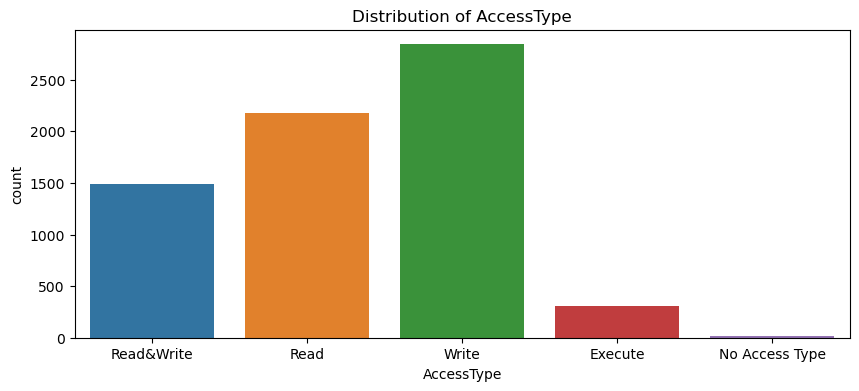

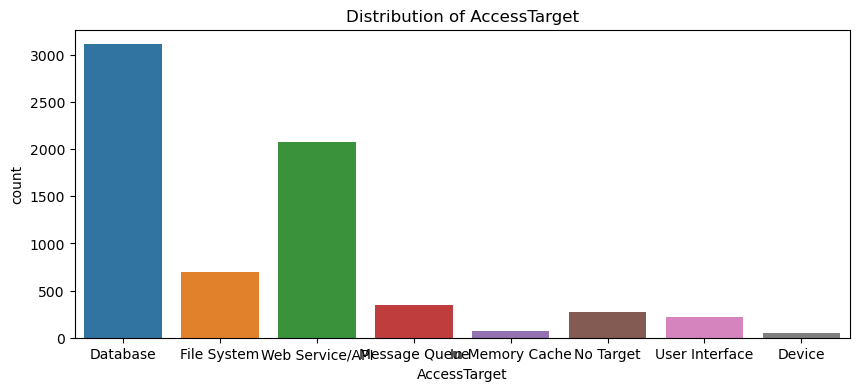

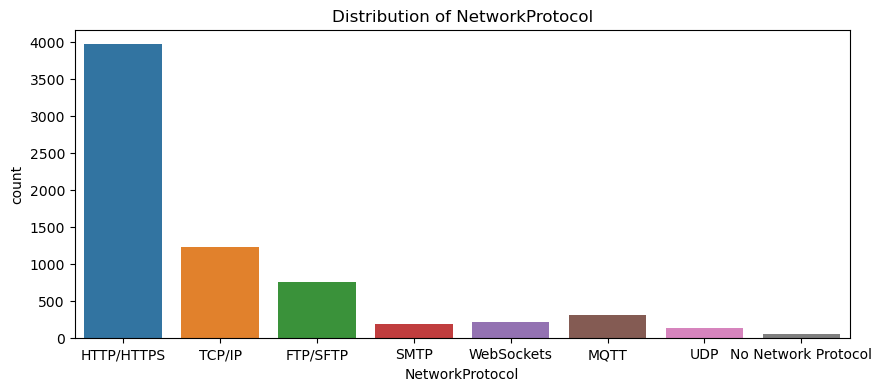

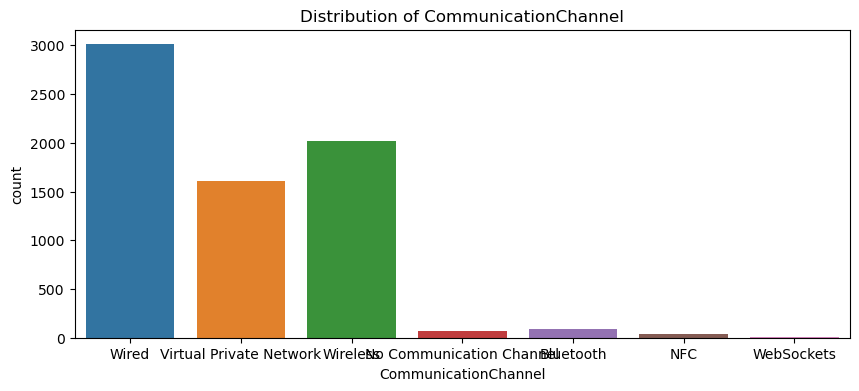

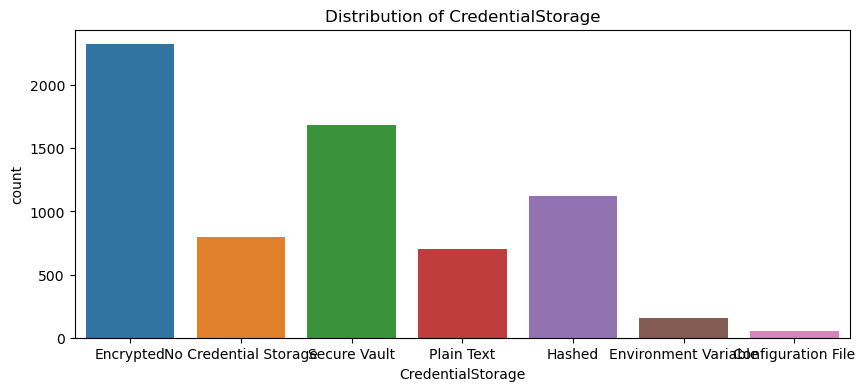

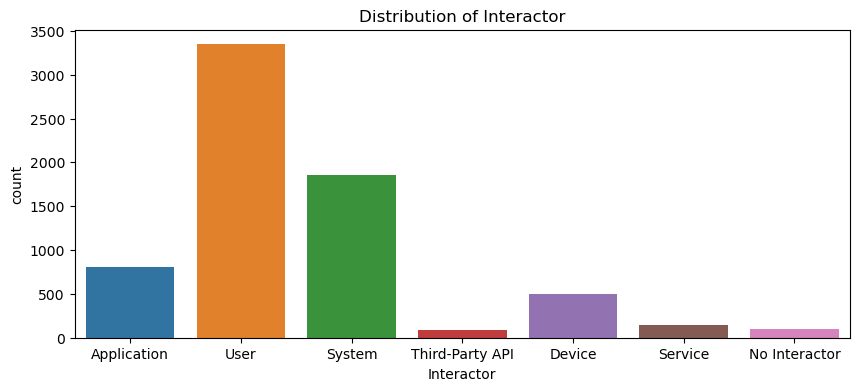

In [12]:
for column in data.drop('Threat', axis=1).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, x=column)
    plt.title(f'Distribution of {column}')
    plt.show()


# Data Encoding

In [13]:
# Separate features and target variable
X = data.drop('Threat', axis=1)
y = data['Threat']

In [14]:
# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert y_encoded to a DataFrame
y_encoded_df = pd.DataFrame(y_encoded, columns=['Encoded Target'])

# One-hot encode the categorical features
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder.fit_transform(X)

# Convert the encoded features to a DataFrame
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder.get_feature_names_out(X.columns))

# Analysis of Data

### Correlation Analysis

In [15]:
# Define the number of top features to select
N = 25

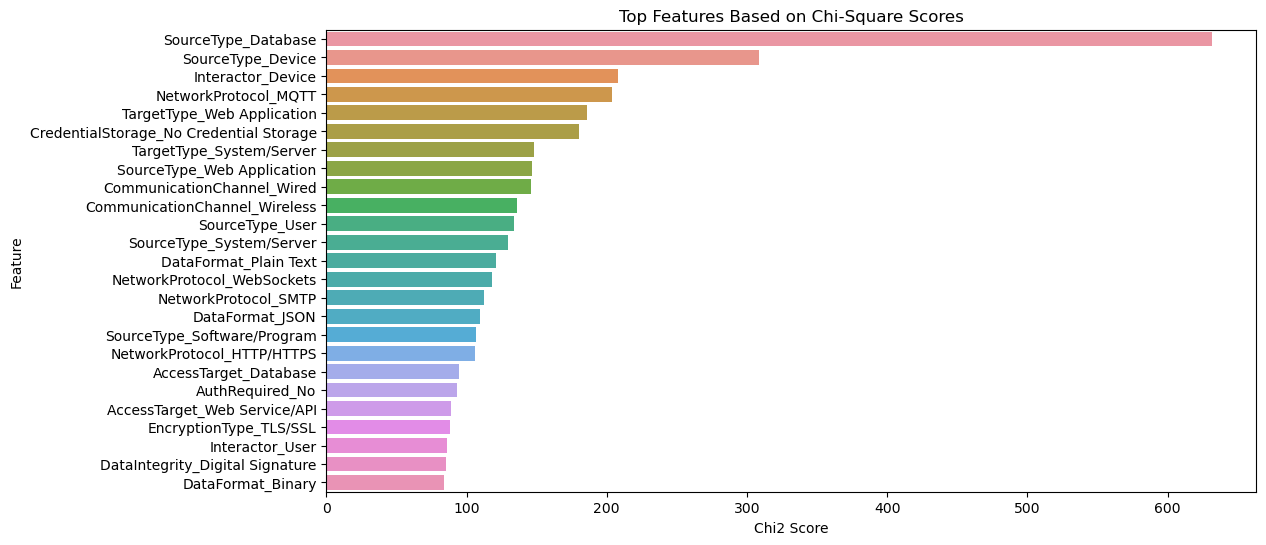

In [16]:
# Chi-Square Test
chi2_scores, p_values = chi2(X_encoded_df, y_encoded)
chi2_results = pd.DataFrame({'Feature': X_encoded_df.columns, 'Chi2 Score': chi2_scores, 'p-value': p_values})
chi2_resultsTOPN = chi2_results.sort_values(by='Chi2 Score', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Chi2 Score', y='Feature', data=chi2_resultsTOPN)
plt.title('Top Features Based on Chi-Square Scores')
plt.show()

In [17]:
chi2_results

,Feature,Chi2 Score,p-value
0,SourceType_Database,631.824286,5.622692e-121
1,SourceType_Device,308.765896,1.305787e-53
2,SourceType_Service,69.341467,2.332139e-07
3,SourceType_Software/Program,106.652906,7.975001e-14
4,SourceType_System/Server,129.371453,5.113451e-18
...,...,...,...
78,Interactor_No Interactor,31.721191,4.636129e-02
79,Interactor_Service,49.958608,2.245183e-04
80,Interactor_System,52.050439,1.119466e-04
81,Interactor_Third-Party API,28.755130,9.269407e-02


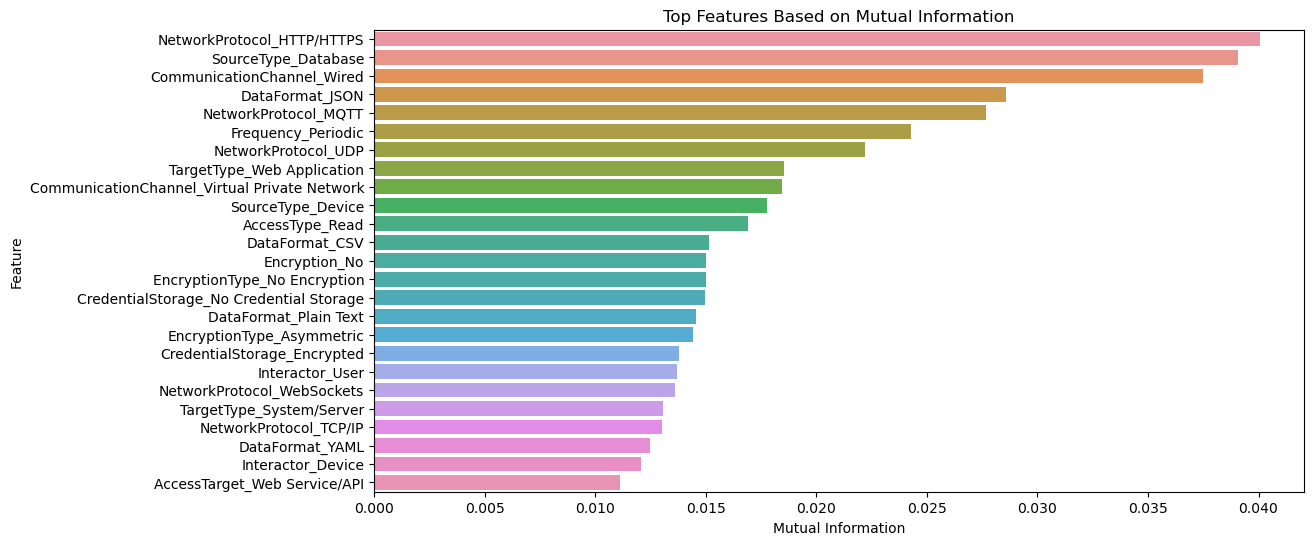

In [18]:
# Mutual Information
mutual_info = mutual_info_classif(X_encoded_df, y_encoded)
mutual_info_df = pd.DataFrame({'Feature': X_encoded_df.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False).head(N)
plt.figure(figsize=(12, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mutual_info_df)
plt.title('Top Features Based on Mutual Information')
plt.show()

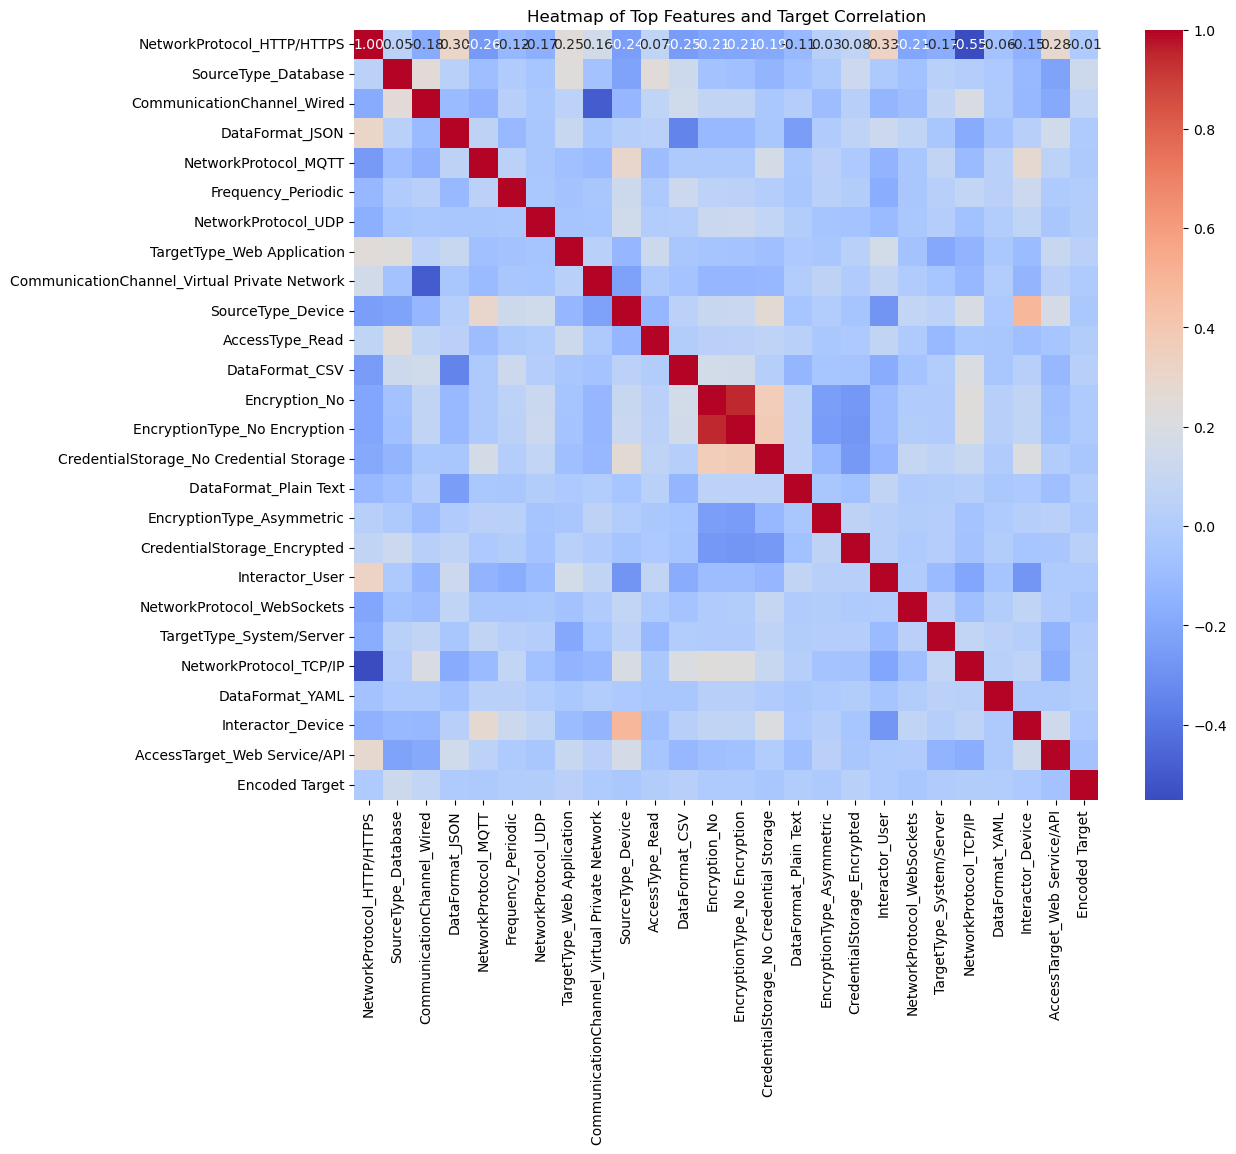

In [19]:
# Select top features based on mutual information (you can choose chi2 if preferred)
top_features = mutual_info_df['Feature']

# Create a heatmap only for the top features
top_features_df = X_encoded_df[top_features]

# Add the target variable for correlation calculation
heatmap_data = top_features_df.join(y_encoded_df)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Top Features and Target Correlation')
plt.show()

<Axes: >

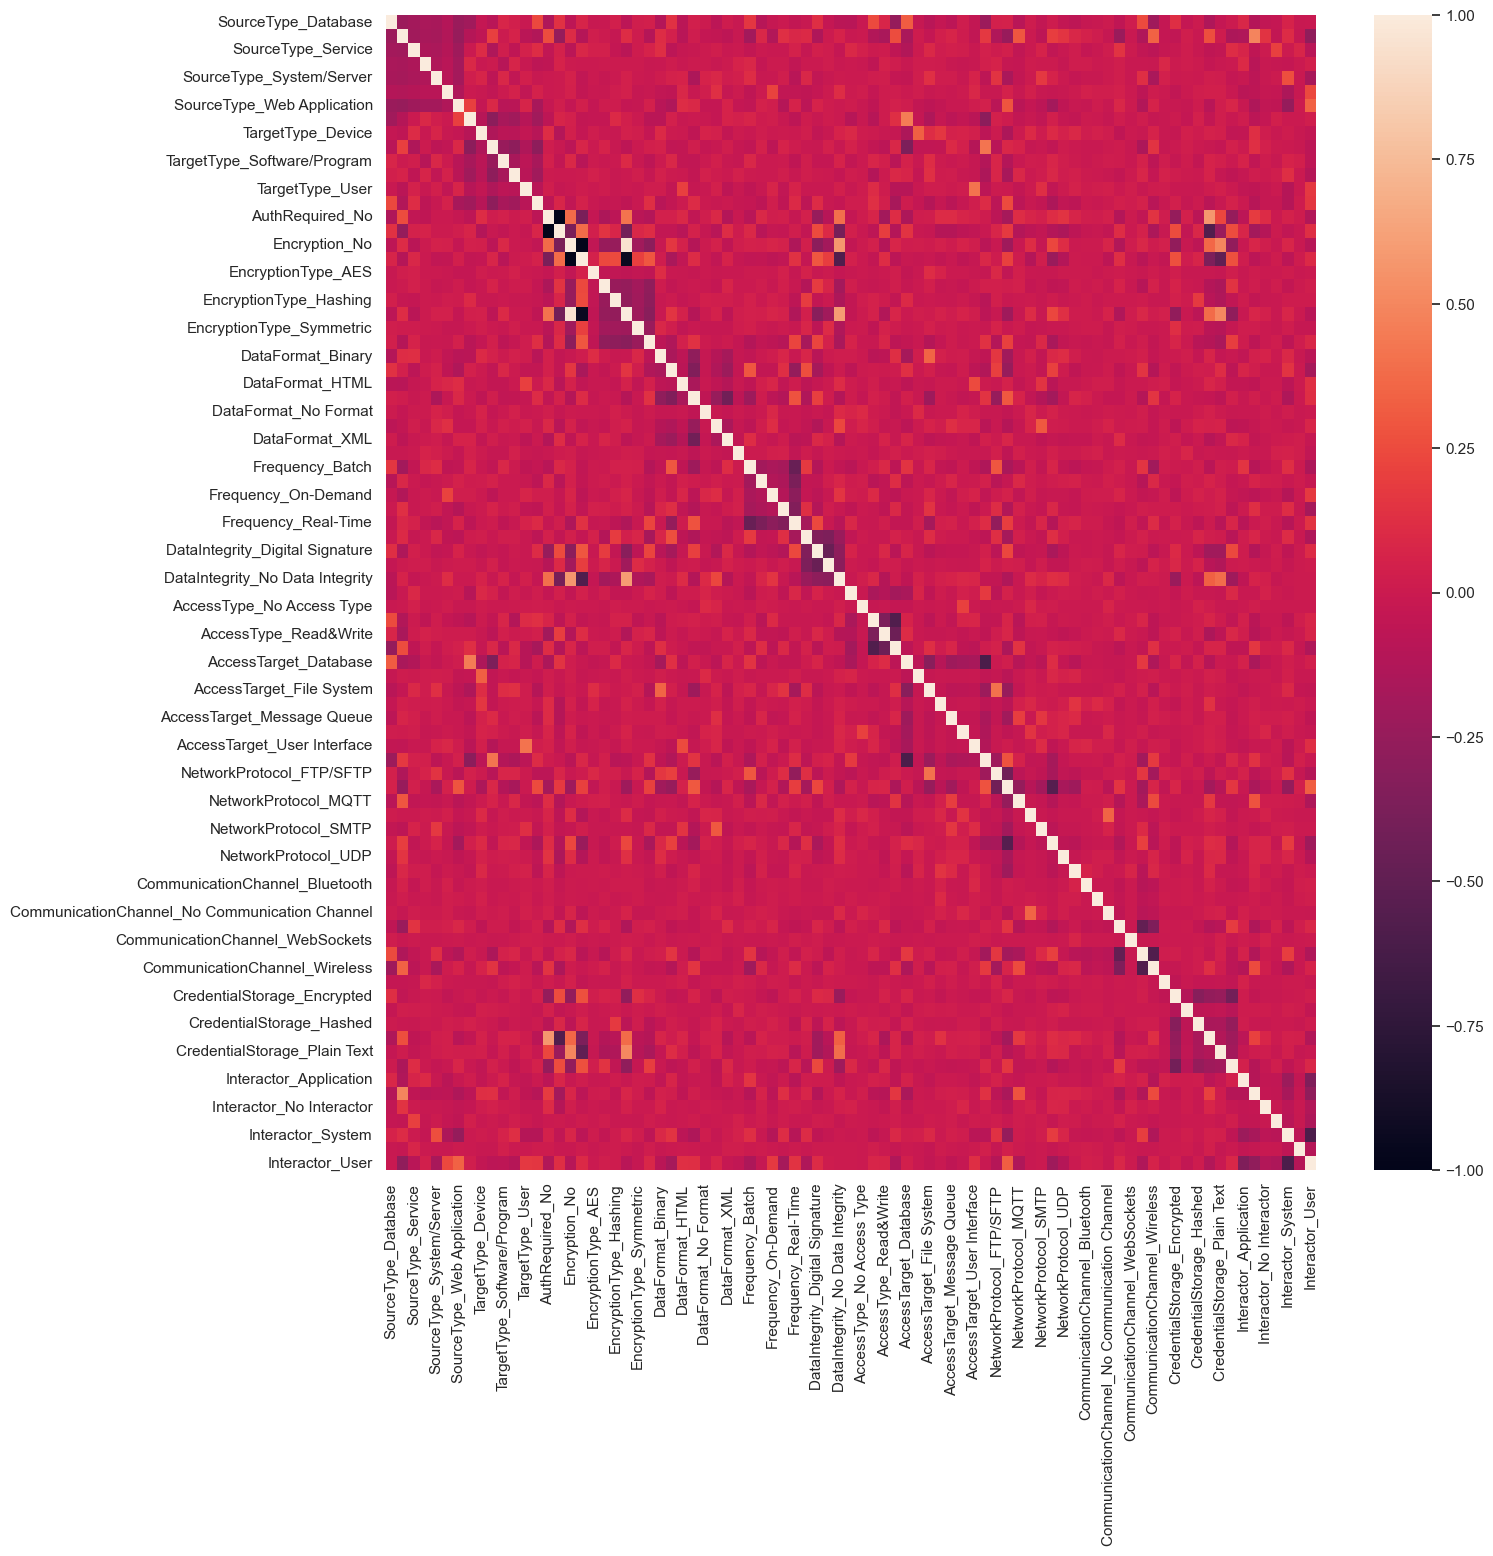

In [20]:
corrtable = pd.DataFrame(data=X_encoded_df).corr()
sns.set_theme(rc={'figure.figsize':(15,15)})
sns.heatmap(corrtable)

# Machine Learning

### Original Split

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Display the preprocessed data
print("Encoded Features:\n", X_encoded_df)
print("Encoded Target:\n", y_encoded)
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)

Encoded Features:
       SourceType_Database  SourceType_Device  SourceType_Service  \
0                     1.0                0.0                 0.0   
1                     0.0                0.0                 0.0   
2                     0.0                0.0                 0.0   
3                     0.0                1.0                 0.0   
4                     0.0                0.0                 0.0   
...                   ...                ...                 ...   
6830                  0.0                1.0                 0.0   
6831                  0.0                0.0                 0.0   
6832                  0.0                0.0                 0.0   
6833                  0.0                0.0                 1.0   
6834                  0.0                0.0                 0.0   

      SourceType_Software/Program  SourceType_System/Server  SourceType_User  \
0                             0.0                       0.0              0.0   
1   

## Algorithms

### Decision Tree

In [22]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize and perform Grid Search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(report)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Accuracy: 0.12189176011701609
              precision    recall  f1-score   support

           0       0.07      0.11      0.08       139
           1       0.03      0.02      0.02        57
           2       0.17      0.03      0.05        63
           3       0.16      0.19      0.17       152
           4       0.07      0.05      0.06       111
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        55
           7       0.00      0.00      0.00        53
           8       0.10      0.08      0.09        60
           9       0.09      0.09      0.09       134
          10       0.08      0.10      0.09       137
          11       0.23      0.23      0.23       140
          12       0.22      0.17      0.19       120
          13       0.10      0.11      0.11   

### Random Forest

In [23]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.11      0.09       139
           1       0.06      0.04      0.04        57
           2       0.03      0.02      0.02        63
           3       0.17      0.20      0.18       152
           4       0.07      0.06      0.07       111
           5       0.09      0.04      0.06        23
           6       0.03      0.02      0.02        55
           7       0.00      0.00      0.00        53
           8       0.00      0.00      0.00        60
           9       0.09      0.09      0.09       134
          10       0.10      0.12      0.11       137
          11       0.21      0.29      0.24       140
          12       0.24      0.25      0.24       120
          13       0.07      0.04      0.05        46
          14       0.12      0.15      0.13       152
          15       0.09      0.10      0.09       124
          16       0.03      0.02      0.02        61
   

In [ ]:
param_grid_rf = {
    'n_estimators': [200, 400, 500, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}

In [ ]:
# Initialize the Randomized Search
randomized_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid_rf, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Fit the randomized search to the data
randomized_search.fit(X_train, y_train)

# Best parameters from randomized search
print("Best Parameters from Randomized Search:")
print(randomized_search.best_params_)

# Predict with the best estimator
best_clf_randomized = randomized_search.best_estimator_
y_pred_best_randomized = best_clf_randomized.predict(X_test)

# Evaluate the tuned model
print("\nConfusion Matrix (Tuned Model - Randomized Search):")
plot_confusion_matrix(y_test, y_pred_best_randomized, classes=classes, title='Randomized Search Confusion Matrix')
print(classification_report(y_test, y_pred_best_randomized, target_names=classes))
print("\nAccuracy Score (Tuned Model - Randomized Search):")
print(accuracy_score(y_test, y_pred_best_randomized))

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Random Forest Classifier on the balanced data
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred_smote = clf_smote.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix (SMOTE):")
plot_confusion_matrix(y_test, y_pred_smote, classes=classes, title='SMOTE Confusion Matrix')
print(classification_report(y_test, y_pred_smote, target_names=classes))
print("\nAccuracy Score (SMOTE):")
print(accuracy_score(y_test, y_pred_smote))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Accuracy: {accuracy_score(y_test, y_pred)}")
    plot_confusion_matrix(y_test, y_pred, classes=classes, title=f'{model_name} Confusion Matrix')
    print(classification_report(y_test, y_pred, target_names=classes))


In [ ]:
# Additional Feature Engineering Steps
# You can create interaction terms, polynomial features, or domain-specific features

# Example: Adding interaction terms (this is just an example; adjust according to your data)
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_encoded_df)

# Convert back to DataFrame for better readability (optional)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_encoded_df.columns))


In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Perform cross-validation
scores = cross_val_score(xgb_clf, X_poly_df, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {scores.mean()}")

# Train and evaluate XGBoost model
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# Evaluate the XGBoost model
print("\nConfusion Matrix (XGBoost):")
plot_confusion_matrix(y_test, y_pred_xgb, classes=classes, title='XGBoost Confusion Matrix')
print(classification_report(y_test, y_pred_xgb, target_names=classes))
print("\nAccuracy Score (XGBoost):")
print(accuracy_score(y_test, y_pred_xgb))


In [ ]:
from sklearn.model_selection import StratifiedKFold

# Initialize Random Forest with best parameters found
best_rf_clf = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=6, criterion='gini', random_state=42)

# Perform stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_rf_clf, X_poly_df, y_encoded, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean()}")

# Train and evaluate Random Forest model with cross-validation
best_rf_clf.fit(X_train, y_train)
y_pred_rf_cv = best_rf_clf.predict(X_test)

# Evaluate the Random Forest model with cross-validation
print("\nConfusion Matrix (Random Forest with Cross-Validation):")
plot_confusion_matrix(y_test, y_pred_rf_cv, classes=classes, title='Random Forest (CV) Confusion Matrix')
print(classification_report(y_test, y_pred_rf_cv, target_names=classes))
print("\nAccuracy Score (Random Forest with Cross-Validation):")
print(accuracy_score(y_test, y_pred_rf_cv))


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_rf_clf, X_poly_df, y_encoded, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

param_range = [100, 200, 300, 400, 500]
train_scores, test_scores = validation_curve(best_rf_clf, X_poly_df, y_encoded, param_name='n_estimators', param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.plot(param_range, train_scores_mean, label='Training Score')
plt.plot(param_range, test_scores_mean, label='Cross-Validation Score')
plt.title('Validation Curve for Random Forest (n_estimators)')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()


In [ ]:
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_encoded_df)

# Convert back to DataFrame for better readability
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_encoded_df.columns))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a Random Forest Classifier
best_rf_clf = RandomForestClassifier(random_state=42)
best_rf_clf.fit(X_train, y_train)

# Extract feature importances
feature_importances = best_rf_clf.feature_importances_
features = poly.get_feature_names_out(X_encoded_df.columns)  # Get feature names from polynomial transformation

# Ensure the lengths match
assert len(features) == len(feature_importances), "The number of features does not match the number of importances."

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

In [ ]:

# Adding regularization using max_depth and min_samples_split
clf_reg = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf_reg.fit(X_train, y_train)
y_pred_reg = clf_reg.predict(X_test)

# Evaluate the regularized model
print("\nConfusion Matrix (Regularized Model):")
plot_confusion_matrix(y_test, y_pred_reg, classes=label_encoder.classes_, title='Regularized Model Confusion Matrix')
print(classification_report(y_test, y_pred_reg, target_names=label_encoder.classes_))
print("\nAccuracy Score (Regularized Model):")
print(accuracy_score(y_test, y_pred_reg))


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Select features based on importance
selector = SelectFromModel(best_rf_clf, threshold='median', prefit=True)
X_selected = selector.transform(X_poly_df)

# Split the selected features data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Retrain and evaluate the model with selected features
clf_sel = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = clf_sel.predict(X_test_sel)

print("\nConfusion Matrix (Feature Selection):")
plot_confusion_matrix(y_test_sel, y_pred_sel, classes=label_encoder.classes_, title='Feature Selection Confusion Matrix')
print(classification_report(y_test_sel, y_pred_sel, target_names=label_encoder.classes_))
print("\nAccuracy Score (Feature Selection):")
print(accuracy_score(y_test_sel, y_pred_sel))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Initialize models
clf1 = RandomForestClassifier(n_estimators=500, max_features='log2', max_depth=10, min_samples_split=10, random_state=42)
clf2 = LogisticRegression(max_iter=1000, random_state=42)
clf3 = SVC(kernel='linear', probability=True, random_state=42)

# Create an ensemble model
eclf = VotingClassifier(estimators=[
    ('rf', clf1), ('lr', clf2), ('svc', clf3)], voting='soft')

# Train ensemble model
eclf.fit(X_train, y_train)
y_pred_ensemble = eclf.predict(X_test)

# Evaluate the ensemble model
print("\nConfusion Matrix (Ensemble Model):")
plot_confusion_matrix(y_test, y_pred_ensemble, classes=label_encoder.classes_, title='Ensemble Model Confusion Matrix')
print(classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_))
print("\nAccuracy Score (Ensemble Model):")
print(accuracy_score(y_test, y_pred_ensemble))


In [ ]:
from sklearn.dummy import DummyClassifier
# Train a Dummy Classifier as a baseline
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluate the Dummy Classifier
print("Dummy Classifier Performance:")
print("\nConfusion Matrix (Dummy Classifier):")
plot_confusion_matrix(y_test, y_pred_dummy, classes=label_encoder.classes_, title='Dummy Classifier Confusion Matrix')
print(classification_report(y_test, y_pred_dummy, target_names=label_encoder.classes_))
print("\nAccuracy Score (Dummy Classifier):")
print(accuracy_score(y_test, y_pred_dummy))

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42)
log_reg_clf.fit(X_train, y_train)
y_pred_log_reg = log_reg_clf.predict(X_test)

# Evaluate the Logistic Regression model
print("\nConfusion Matrix (Logistic Regression):")
plot_confusion_matrix(y_test, y_pred_log_reg, classes=label_encoder.classes_, title='Logistic Regression Confusion Matrix')
print(classification_report(y_test, y_pred_log_reg, target_names=label_encoder.classes_))
print("\nAccuracy Score (Logistic Regression):")
print(accuracy_score(y_test, y_pred_log_reg))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assume X and y are your features and target
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(), X_encoded_df, y_encoded, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
STOP

In [ ]:
# Assuming your trained model is stored in grid_search
# and you have the training data stored in X_train_res and y_train_res

# Predict on the training set
y_train_pred = grid_search.predict(X_train)

# Decode the predictions and the true labels back to original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)

# Evaluate the model on the training set
print("Performance on the training set:")
print("Accuracy:", accuracy_score(y_train_decoded, y_train_pred_decoded))
print("Classification Report:\n", classification_report(y_train_decoded, y_train_pred_decoded))

# Additional metrics can be added here if needed


In [ ]:
import pickle

# Create the pipeline with the preprocessor and the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X, y_encoded)

# Save the model and preprocessor to a pickle file
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(grid_search, file)


# OneHot Encoding the target variable

In [24]:
source = data #options: data, data_reduced, filtered_data

In [25]:
# Encode the categorical features using OneHotEncoder
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(source.drop('Threat', axis=1))

# Convert the encoded features to a DataFrame for better readability (optional)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(source.drop('Threat', axis=1).columns))

# One-hot encode the target variable
onehot_encoder_target = OneHotEncoder(sparse_output=False)  # Set sparse=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(source[['Threat']])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, source['Threat'])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Random Forest Algorithm

In [26]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)
print("\nInitial Classification Report:")
print(classification_report(y_test, y_pred))
print("\nInitial Accuracy Score:", accuracy)


Initial Classification Report:
                                      precision    recall  f1-score   support

                 API Security Breach       0.16      0.20      0.18       101
                 Credential Stuffing       0.66      0.66      0.66       101
   Cross-Site Request Forgery (CSRF)       0.65      0.69      0.67       101
          Cross-Site Scripting (XSS)       0.21      0.23      0.22       101
                       Cryptojacking       0.29      0.23      0.25       102
             Denial of Service (DoS)       0.78      0.92      0.85       101
                 Directory Traversal       0.68      0.74      0.70       102
Distributed Denial of Service (DDoS)       0.73      0.75      0.74       102
           Drive-by Download Attacks       0.67      0.67      0.67       101
                        Malvertising       0.19      0.18      0.18       102
                      Malware Attack       0.18      0.15      0.16       102
     Man-in-the-Middle (MitM) A

In [27]:
low_accuracy_classes = [
    'API Security Breach', 'Cross-Site Scripting (XSS)', 'Cryptojacking', 
    'Malvertising', 'Malware Attack', 'Man-in-the-Middle (MitM) Attack', 
    'Phishing Attacks', 'Ransomware Attack', 'Zero-day Exploit', 'SQL Injection', 'Spear Phishing Attacks'
]

# Drop the rows with low accuracy classes
top_data = data[~data['Threat'].isin(low_accuracy_classes)]

# Encode the categorical features using OneHotEncoder
onehot_encoder_features = OneHotEncoder(handle_unknown='ignore')
X_encoded = onehot_encoder_features.fit_transform(top_data.drop('Threat', axis=1))

# Convert the encoded features to a DataFrame for better readability (optional)
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=onehot_encoder_features.get_feature_names_out(top_data.drop('Threat', axis=1).columns))

# One-hot encode the target variable
onehot_encoder_target = OneHotEncoder(sparse_output=False)  # Set sparse=False to get a dense array
y_encoded = onehot_encoder_target.fit_transform(top_data[['Threat']])

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded_df, top_data['Threat'])

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train a new random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [28]:
# Make predictions and evaluate the model
y_pred = rf_classifier.predict(X_test)
report = classification_report(y_test, y_pred, target_names=onehot_encoder_target.categories_[0])
print(report)

                                      precision    recall  f1-score   support

                 Credential Stuffing       0.73      0.71      0.72        80
   Cross-Site Request Forgery (CSRF)       0.61      0.64      0.63        80
             Denial of Service (DoS)       0.86      0.84      0.85        80
                 Directory Traversal       0.76      0.72      0.74        81
Distributed Denial of Service (DDoS)       0.71      0.75      0.73        80
           Drive-by Download Attacks       0.68      0.74      0.71        80
                           No Threat       0.58      0.54      0.56        81
                     Password Attack       0.75      0.74      0.74        80
         Remote Code Execution (RCE)       0.71      0.69      0.70        80
                 Side-Channel Attack       0.66      0.69      0.67        80

                            accuracy                           0.70       802
                           macro avg       0.71      0.70     

In [29]:
import pickle
# Save the model and preprocessor to a pickle file
#with open('RF_algorithm_1.0.4.pkl', 'wb') as file:
#    pickle.dump((rf_classifier, onehot_encoder_features), file)

In [30]:
class_counts = top_data['Threat'].value_counts()
class_counts

Threat
No Threat                               401
Cross-Site Request Forgery (CSRF)       209
Remote Code Execution (RCE)             204
Drive-by Download Attacks               200
Credential Stuffing                     191
Directory Traversal                     183
Distributed Denial of Service (DDoS)    176
Side-Channel Attack                     171
Password Attack                         153
Denial of Service (DoS)                  78
Name: count, dtype: int64

In [36]:
# Check the number of trees in the forest
print(f"Number of trees in the forest: {rf_classifier.n_estimators}")

# List of all trees in the forest
trees = rf_classifier.estimators_

# Display parameters of the Random Forest
print(rf_classifier.get_params())


Number of trees in the forest: 100
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [49]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [41]:
# Assuming onehot_encoder_target.categories_[0] gives the class names
class_names = onehot_encoder_target.categories_[0]

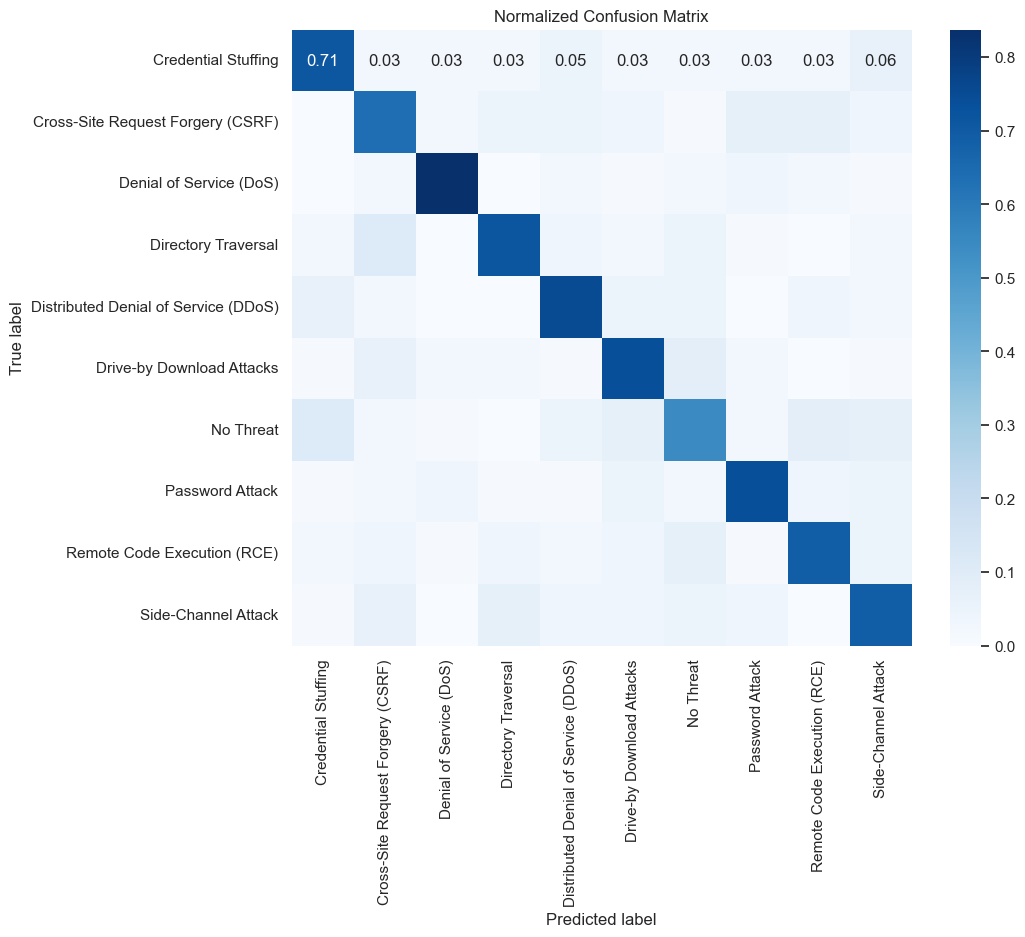

In [42]:
# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

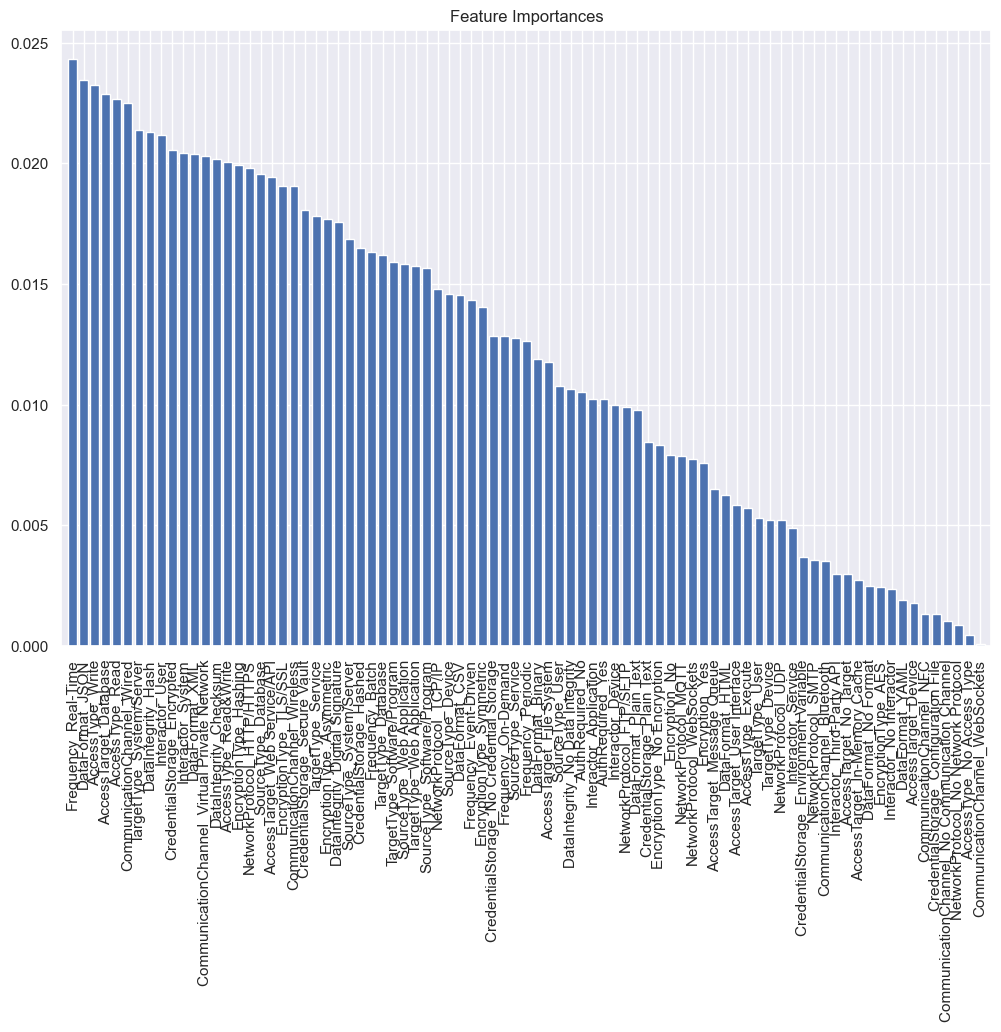

In [44]:
# Plot the feature importances
def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.show()
plot_feature_importances(rf_classifier, X_encoded_df.columns)

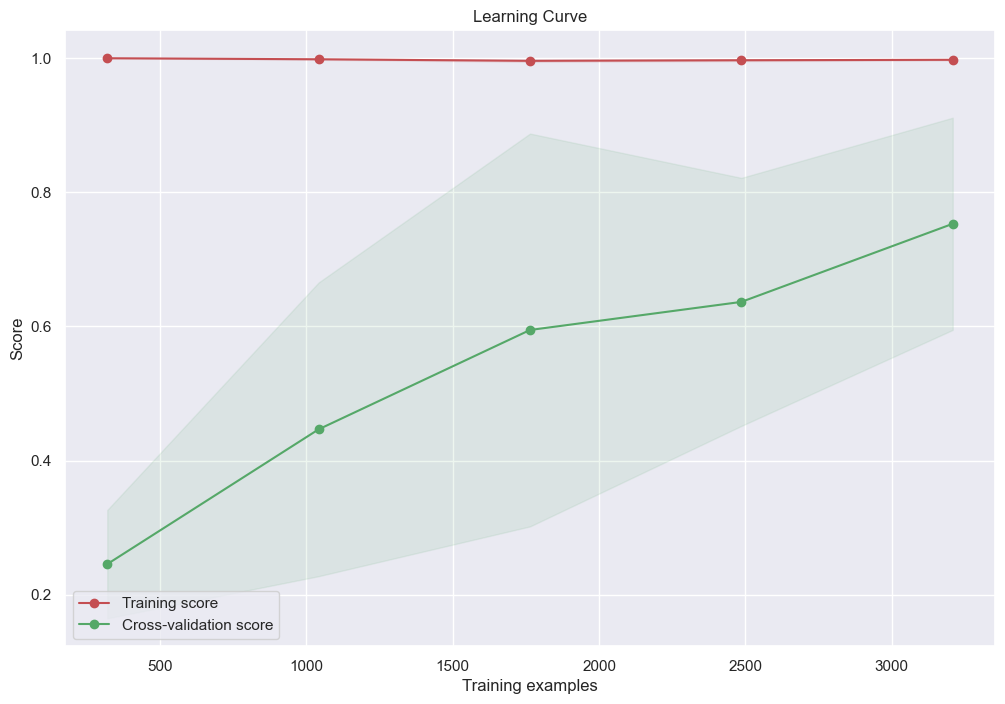

In [51]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title='Learning Curve'):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(rf_classifier, X_resampled, y_resampled)


In [58]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [1500, 2000],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_best = best_rf_classifier.predict(X_test)
report_best = classification_report(y_test, y_pred_best, target_names=onehot_encoder_target.categories_[0])
print(report_best)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}
                                      precision    recall  f1-score   support

                 Credential Stuffing       0.79      0.74      0.76        80
   Cross-Site Request Forgery (CSRF)       0.64      0.66      0.65        80
             Denial of Service (DoS)       0.86      0.84      0.85        80
                 Directory Traversal       0.82      0.78      0.80        81
Distributed Denial of Service (DDoS)       0.79      0.76      0.78        80
           Drive-by Download Attacks       0.68      0.72      0.70        80
                           No Threat       0.59      0.54      0.56        81
                     Password Attack       0.71      0.75      0.73        80
         Remote Code Execution (RCE)       0.69      0.74      0.71        80
                 Side-Channel Attack       0.71  

# Decision Tree visualisation

In [31]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
import pydotplus
import re

In [32]:
tree = rf_classifier.estimators_[0]

In [33]:
# Function to sanitize feature names
def sanitize_feature_names(feature_names):
    sanitized_names = []
    for name in feature_names:
        sanitized_name = re.sub(r"[<>&]", "", name)
        sanitized_names.append(sanitized_name)
    return sanitized_names

In [34]:
# Export as dot file
dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=sanitize_feature_names(onehot_encoder_features.get_feature_names_out(top_data.drop('Threat', axis=1).columns)),  
                           class_names=onehot_encoder_target.categories_[0], 
                           filled=True, rounded=True,  
                           special_characters=True)  

# Create a graph from dot data
graph = pydotplus.graph_from_dot_data(dot_data)  

In [35]:
#graph.write_pdf("decision_tree.pdf")